In [1]:
from google.colab import drive
drive.mount("./drive")

Mounted at ./drive


In [2]:
!pip install livelossplot

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *

from livelossplot import PlotLossesKeras

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.ensemble import *

import cv2
from PIL import Image

import numpy as np
import scipy
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm, notebook

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile
print("All modules are successfull loaded")

All modules are successfull loaded


In [4]:
with ZipFile("./drive/MyDrive/DockShip_Hiring_Challenge/attentive_ai_internship_hiring_challenge-dataset.zip") as file:
    file.extractall()
file.close()
print("Extraction Done")

Extraction Done


In [5]:
TRAIN_DATA = "./merged_data/train"
TEST_DATA = "./merged_data/test"
TRAIN_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/train_csv.csv"
TEST_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/test_csv.csv"
WORK_DIR = "./drive/MyDrive/DockShip_Hiring_Challenge/"

# Time to get our hands dirty

In [6]:
train_csv = pd.read_csv(TRAIN_CSV)
test_csv = pd.read_csv(TEST_CSV)

In [7]:
train_csv

,0,1,paths,img_shape
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)"
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)"
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)"
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)"
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)"
...,...,...,...,...
8639,8639.jpg,Adhered,./merged_data/train/8639.jpg,"(3, 1502, 1598)"
8640,8640.jpg,Adhered,./merged_data/train/8640.jpg,"(3, 1674, 358)"
8641,8641.jpg,Adhered,./merged_data/train/8641.jpg,"(3, 4070, 6005)"
8642,8642.jpg,Adhered,./merged_data/train/8642.jpg,"(3, 294, 493)"


In [8]:
test_csv

,0,1,paths,img_shape
0,0.jpg,Adhered,./merged_data/test/0.jpg,"(3, 609, 388)"
1,1.jpg,Adhered,./merged_data/test/1.jpg,"(3, 90, 43)"
2,2.jpg,Adhered,./merged_data/test/2.jpg,"(3, 211, 365)"
3,3.jpg,Adhered,./merged_data/test/3.jpg,"(3, 1818, 913)"
4,4.jpg,Adhered,./merged_data/test/4.jpg,"(3, 433, 105)"
...,...,...,...,...
591,591.jpg,Adhered,./merged_data/test/591.jpg,"(3, 4080, 3220)"
592,592.jpg,Adhered,./merged_data/test/592.jpg,"(3, 635, 682)"
593,593.jpg,Adhered,./merged_data/test/593.jpg,"(3, 117, 284)"
594,594.jpg,Adhered,./merged_data/test/594.jpg,"(3, 901, 720)"


# Augmenting data

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

for idx,(tr_,te_) in enumerate(skf.split(train_csv["paths"],y=train_csv["1"])):
    train_csv.loc[te_,'kfold']=idx

In [10]:
train_csv

,0,1,paths,img_shape,kfold
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)",3.0
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)",1.0
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)",1.0
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)",0.0
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)",1.0
...,...,...,...,...,...
8639,8639.jpg,Adhered,./merged_data/train/8639.jpg,"(3, 1502, 1598)",1.0
8640,8640.jpg,Adhered,./merged_data/train/8640.jpg,"(3, 1674, 358)",0.0
8641,8641.jpg,Adhered,./merged_data/train/8641.jpg,"(3, 4070, 6005)",0.0
8642,8642.jpg,Adhered,./merged_data/train/8642.jpg,"(3, 294, 493)",1.0


In [11]:
len(os.listdir("./merged_data/train"))

8644

In [12]:
def dataAugmentWithSkf(train_data, img_shape, preprocessing_function=None, batch_size = 64, img_dir = "/content/merged_data/train", x_col = "paths", y_col = "1"):

    train_data[y_col] = train_data[y_col].astype(str) 
    train_exmpls = train_data[train_data.kfold!=0]
    val_exmpls = train_data[train_data.kfold==0]
    # train_data[y_col] = train_data[y_col].astype('float32')

    trainGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                  rotation_range = 270,
                                  zoom_range = 0.2,
                                #   cval = 0.,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                #   shear_range = 0.15,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  brightness_range = [0.2, 0.5],
                                  rescale = 1/255.,                       
                                )

    train_set = trainGen.flow_from_dataframe(train_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )

    valGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                rescale = 1/255.                                
                                )

    val_set = valGen.flow_from_dataframe(val_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )
       
    return train_set, val_set

In [13]:
img_shape = [224, 224]
train_set, val_set = dataAugmentWithSkf(train_csv,
                                        img_shape,
                                        x_col = "0",
                                        y_col = '1',
                                        )

Found 6915 validated image filenames belonging to 6 classes.
Found 1729 validated image filenames belonging to 6 classes.


In [14]:
classes = train_set.class_indices
classes

{'Adhered': 0,
 'Ballasted': 1,
 'Concrete': 2,
 'Plastic & fabric': 3,
 'Shingle': 4,
 'Steel': 5}

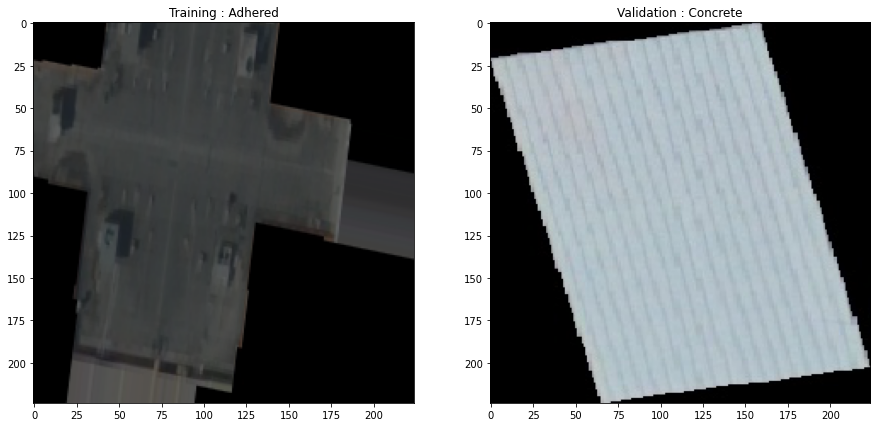

In [15]:
idx = np.random.randint(len(next(train_set)[0]))
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.imshow((next(train_set)[0][idx]));
plt.title(f"Training : {list(classes.keys())[list(next(train_set)[1][idx]).index(1)]}")

plt.subplot(1, 2, 2)
plt.imshow((next(val_set)[0][idx]));
plt.title(f"Validation : {list(classes.keys())[list(next(val_set)[1][idx]).index(1)]}")
plt.show();

# Building a model

In [87]:
def create_model(img_shape = 224, n_classes = 6):

    pmodel = InceptionV3(input_shape = (img_shape, img_shape, 3), include_top = False,
                             weights = 'imagenet')
    layer_count = 0
    untrained_layers = 0
    tlayers = len(list(pmodel.layers))
    
    # print(f"last layer_name : {list(pmodel.layers)[len(pmodel.layers)-1].name}")
    for i, layer in enumerate(pmodel.layers):
        if i > tlayers//2:
            layer.trainable = True
            print(i, layer.name)
            untrained_layers += 1
        else:
            layer.trainable = False
    
    print()
    print(f"Total layers : {tlayers}")
    print(f"Total Trainable Layers : {untrained_layers}")
    
    x = GlobalAveragePooling2D()(pmodel.output)
    x = Dense(256, activation = 'relu', kernel_initializer='he_uniform')(x)
    # x = Dropout(0.5)(x)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(inputs = pmodel.input, outputs = output, name = pmodel.name)
    return model

model = create_model()

156 batch_normalization_439
157 batch_normalization_442
158 batch_normalization_447
159 batch_normalization_448
160 activation_431
161 activation_434
162 activation_439
163 activation_440
164 mixed5
165 conv2d_453
166 batch_normalization_453
167 activation_445
168 conv2d_454
169 batch_normalization_454
170 activation_446
171 conv2d_450
172 conv2d_455
173 batch_normalization_450
174 batch_normalization_455
175 activation_442
176 activation_447
177 conv2d_451
178 conv2d_456
179 batch_normalization_451
180 batch_normalization_456
181 activation_443
182 activation_448
183 average_pooling2d_24
184 conv2d_449
185 conv2d_452
186 conv2d_457
187 conv2d_458
188 batch_normalization_449
189 batch_normalization_452
190 batch_normalization_457
191 batch_normalization_458
192 activation_441
193 activation_444
194 activation_449
195 activation_450
196 mixed6
197 conv2d_463
198 batch_normalization_463
199 activation_455
200 conv2d_464
201 batch_normalization_464
202 activation_456
203 conv2d_460
204 co

In [88]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_399 (Conv2D)             (None, 111, 111, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_399 (BatchN (None, 111, 111, 32) 96          conv2d_399[0][0]                 
__________________________________________________________________________________________________
activation_391 (Activation)     (None, 111, 111, 32) 0           batch_normalization_399[0][0]    
_______________________________________________________________________________________

In [89]:
plot_model(model, to_file=os.path.join(WORK_DIR, f"{model.name}.png"), show_shapes=True, show_layer_names=True)

In [90]:
# class_weights = {}
# sum = 0
# for class_ in classes:
#     class_weights[classes[class_]] = 1/(len(train_csv[train_csv['1'] == class_])/len(train_csv))
#     sum += 1/(len(train_csv[train_csv['1'] == class_])/len(train_csv))
# class_weights

In [91]:
n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, 
                              verbose=1, mode='min', min_lr = 1e-7)

model_Best_save = ModelCheckpoint(f"/content/ModelCheckpoints/{model.name}.h5",
                                                    monitor = "val_auc",
                                                    save_weights = True,
                                                    save_best_only = True,
                                                    mode = "min"
                                                    )
LR = 1e-3
model.compile(loss = 'categorical_crossentropy',
            #   loss_weights= class_weights,
              metrics = ['accuracy', 'AUC'],
              optimizer = Adam(lr = LR)
              )

callbacks = [model_Best_save, early_stop, reduce_lr]

In [92]:
training_history = model.fit(train_set,
                             validation_data = val_set,
                             callbacks = callbacks,
                             epochs = n_epoch,
                            #  class_weight = class_weights,
                             verbose = 1)

Epoch 1/50
109/109 [==============================] - 185s 2s/step - loss: 1.1871 - accuracy: 0.5554 - auc: 0.8512 - val_loss: 2.4850 - val_accuracy: 0.5304 - val_auc: 0.7995
Epoch 2/50
109/109 [==============================] - 177s 2s/step - loss: 0.7249 - accuracy: 0.7326 - auc: 0.9459 - val_loss: 0.8153 - val_accuracy: 0.7282 - val_auc: 0.9401
Epoch 3/50
109/109 [==============================] - 177s 2s/step - loss: 0.6697 - accuracy: 0.7497 - auc: 0.9541 - val_loss: 0.7926 - val_accuracy: 0.7681 - val_auc: 0.9474
Epoch 4/50
109/109 [==============================] - 177s 2s/step - loss: 0.6176 - accuracy: 0.7599 - auc: 0.9608 - val_loss: 0.6743 - val_accuracy: 0.7791 - val_auc: 0.9579
Epoch 5/50
109/109 [==============================] - 177s 2s/step - loss: 0.5402 - accuracy: 0.8008 - auc: 0.9698 - val_loss: 0.8549 - val_accuracy: 0.7253 - val_auc: 0.9400
Epoch 6/50
109/109 [==============================] - 176s 2s/step - loss: 0.5407 - accuracy: 0.7974 - auc: 0.9696 - val_loss

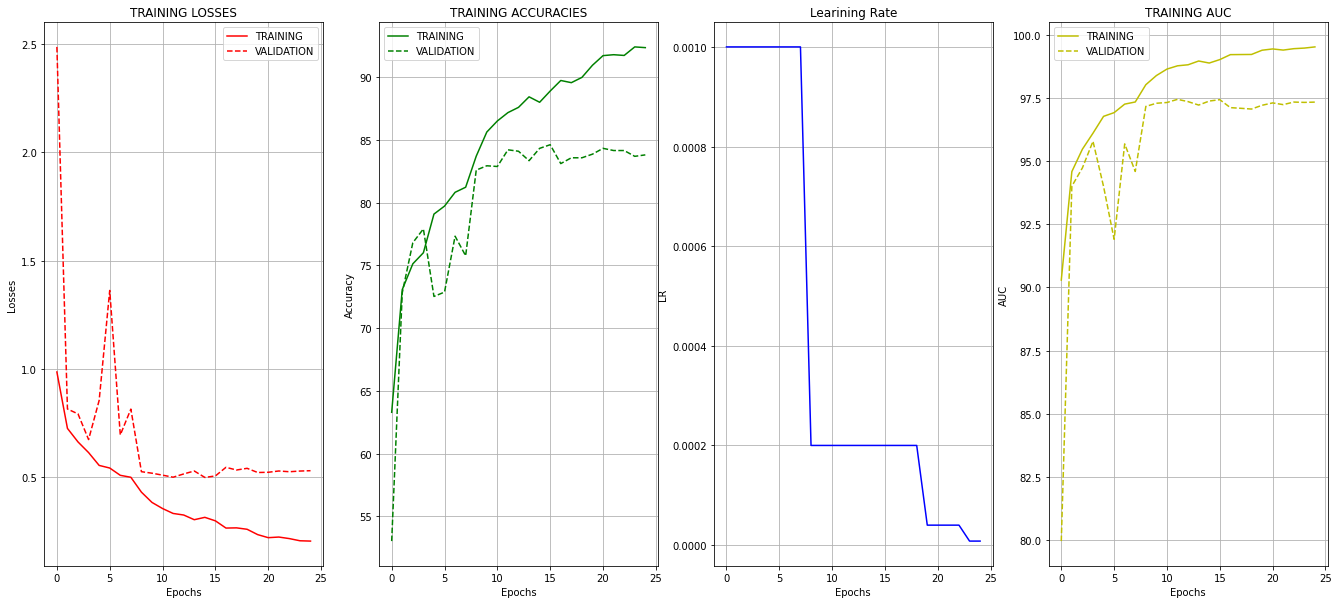

In [93]:
epochs = [d for d in range(len(training_history.history['loss']))]
loss = training_history.history['loss']; val_loss = training_history.history['val_loss']
acc = [d*100 for d in training_history.history['accuracy']]; val_acc = [d*100 for d in training_history.history['val_accuracy']]
auc = [d*100 for d in training_history.history['auc']]; val_auc = [d*100 for d in training_history.history['val_auc']]
lr = training_history.history['lr']

plt.figure(figsize = (23, 10))
plt.subplot(1, 4, 1)
plt.plot(epochs, loss, "-r", )
plt.plot(epochs, val_loss, "--r", )
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING LOSSES")

plt.subplot(1, 4, 2)
plt.plot(epochs, acc, "-g")
plt.plot(epochs, val_acc, "--g")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING ACCURACIES")

plt.subplot(1, 4, 3)
plt.plot(epochs, lr, "-b")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("LR")
plt.title("Learining Rate")

plt.subplot(1, 4, 4)
plt.plot(epochs, auc, "-y")
plt.plot(epochs, val_auc, "--y")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING AUC")

plt.savefig(os.path.join(WORK_DIR, f"{model.name}_training_history.png"));
plt.show();

model.save(os.path.join(WORK_DIR, f"{model.name}_{round(val_acc[-1])}.h5"))

# Performing a submission


In [94]:
os.listdir(WORK_DIR)

['attentive_ai_internship_hiring_challenge-dataset.zip',
 'sample_imgs.png',
 'effb0_avg_pretrained.png',
 'train_csv.csv',
 'test_csv.csv',
 'ResNet50_notTrained.png',
 'ResNet50_52.h5',
 'EffNet0_notTrained.png',
 'EffNetB0_training_history.png',
 'EffNetB0_67.09080338478088.h5',
 'EffNet0_preTrained.png',
 'ResNet50_preTrained.png',
 'ResNet50',
 'ResNet50_35.62752902507782.h5',
 'ResNet50_training_history.png',
 'ResNet50.png',
 'resnet50v2.png',
 'Transfer Learning for Optical Satellite Images.pdf',
 'resnet50v2_training_history.png',
 'resnet50v2_83.1116259098053.h5',
 'DockShip_BaseLineModel_Xception.ipynb',
 'efficientnetb4.png',
 'inception_resnet_v2.png',
 'inception_resnet_v2_training_history.png',
 'inception_resnet_v2_83.74783396720886.h5',
 'inception_resnet_v2_84.h5',
 'inception_resnet_v2_acc_84.h5',
 'xception.png',
 'xception_training_history.png',
 'xception_85.h5',
 'xception_acc_85.h5',
 'inception_v3.png',
 'inception_v3_training_history.png',
 'inception_v3_84.h5

In [95]:
!ls ./ModelCheckpoints

efficientnetb4.h5	       inception_v3.h5
inception_resnet_v2_acc_84.h5  xception_acc_85.h5


In [98]:
sub_model = load_model(os.path.join(WORK_DIR, 'inception_v3_84.h5'))

In [99]:
sub_model.evaluate(val_set)

28/28 [==============================] - 21s 701ms/step - loss: 0.4997 - accuracy: 0.8433 - auc: 0.9739


[0.4996698796749115, 0.8432620167732239, 0.9738531112670898]

In [73]:
# !cp ./ModelCheckpoints/inception_v3.h5 ./drive/MyDrive/DockShip_Hiring_Challenge/

In [100]:
sub_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_399 (Conv2D)             (None, 111, 111, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_399 (BatchN (None, 111, 111, 32) 96          conv2d_399[0][0]                 
__________________________________________________________________________________________________
activation_391 (Activation)     (None, 111, 111, 32) 0           batch_normalization_399[0][0]    
_______________________________________________________________________________________

In [49]:
# test_imgs = []; train_imgs = []
# for img_path in tqdm(test_csv.paths):
#     img = cv2.imread(img_path)
#     img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
#     test_imgs.append(img)

# for img_path in tqdm(train_csv.iloc[:len(test_csv), :].paths):
#     img = cv2.imread(img_path)
#     img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
#     train_imgs.append(img)

# test_imgs = np.array(test_imgs)
# train_imgs = np.array(train_imgs)

100%|██████████| 596/596 [00:02<00:00, 216.26it/s]


In [101]:
test_imgs.shape, train_imgs.shape

((596, 224, 224, 3), (596, 224, 224, 3))

In [102]:
def giveMeClass(x):
    for key, val in classes.items():
        if val == x:
            return key
    return -1

test_preds = sub_model.predict(test_imgs)
train_preds = sub_model.predict(train_imgs)
tpreds = []
trpreds = []
for test_pred in tqdm(test_preds):
    tpreds.append(np.argmax(test_pred))

for train_pred in tqdm(train_preds):
    trpreds.append(np.argmax(train_pred))

train_check = train_csv.iloc[:len(test_csv), :]

train_check['Model_preds'] = trpreds
train_check['Model_preds'] = train_check['Model_preds'].apply(lambda x: giveMeClass(x))

test_csv['Model_preds'] = tpreds
test_csv['Model_preds'] = test_csv['Model_preds'].apply(lambda x: giveMeClass(x))

100%|██████████| 596/596 [00:00<00:00, 155036.29it/s]


In [104]:
train_check

,0,1,paths,img_shape,kfold,Model_preds
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)",3.0,Adhered
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)",1.0,Adhered
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)",1.0,Concrete
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)",0.0,Adhered
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)",1.0,Steel
...,...,...,...,...,...,...
591,591.jpg,Steel,./merged_data/train/591.jpg,"(3, 112, 127)",2.0,Steel
592,592.jpg,Plastic & fabric,./merged_data/train/592.jpg,"(3, 556, 666)",0.0,Plastic & fabric
593,593.jpg,Plastic & fabric,./merged_data/train/593.jpg,"(3, 719, 119)",1.0,Plastic & fabric
594,594.jpg,Plastic & fabric,./merged_data/train/594.jpg,"(3, 196, 166)",1.0,Plastic & fabric


In [105]:
test_csv

,0,1,paths,img_shape,Model_preds
0,0.jpg,Adhered,./merged_data/test/0.jpg,"(3, 609, 388)",Ballasted
1,1.jpg,Adhered,./merged_data/test/1.jpg,"(3, 90, 43)",Steel
2,2.jpg,Adhered,./merged_data/test/2.jpg,"(3, 211, 365)",Adhered
3,3.jpg,Adhered,./merged_data/test/3.jpg,"(3, 1818, 913)",Concrete
4,4.jpg,Adhered,./merged_data/test/4.jpg,"(3, 433, 105)",Steel
...,...,...,...,...,...
591,591.jpg,Adhered,./merged_data/test/591.jpg,"(3, 4080, 3220)",Plastic & fabric
592,592.jpg,Adhered,./merged_data/test/592.jpg,"(3, 635, 682)",Steel
593,593.jpg,Adhered,./merged_data/test/593.jpg,"(3, 117, 284)",Plastic & fabric
594,594.jpg,Adhered,./merged_data/test/594.jpg,"(3, 901, 720)",Ballasted


In [106]:
print(classification_report(test_csv['1'], test_csv['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       1.00      0.18      0.30       596
       Ballasted       0.00      0.00      0.00         0
        Concrete       0.00      0.00      0.00         0
Plastic & fabric       0.00      0.00      0.00         0
         Shingle       0.00      0.00      0.00         0
           Steel       0.00      0.00      0.00         0

        accuracy                           0.18       596
       macro avg       0.17      0.03      0.05       596
    weighted avg       1.00      0.18      0.30       596



In [107]:
print(classification_report(train_check['1'], train_check['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       0.93      0.90      0.92       366
       Ballasted       0.72      0.95      0.82        19
        Concrete       0.89      0.63      0.74        65
Plastic & fabric       0.81      0.74      0.77        57
         Shingle       0.91      0.89      0.90        35
           Steel       0.57      0.91      0.70        54

        accuracy                           0.86       596
       macro avg       0.81      0.83      0.81       596
    weighted avg       0.87      0.86      0.86       596



In [108]:
submission = test_csv[['0', 'Model_preds']]
submission.rename({'Model_preds': "1"}, axis = 1, inplace = True)
submission.to_csv('output.csv', index = False)
submission

,0,1
0,0.jpg,Ballasted
1,1.jpg,Steel
2,2.jpg,Adhered
3,3.jpg,Concrete
4,4.jpg,Steel
...,...,...
591,591.jpg,Plastic & fabric
592,592.jpg,Steel
593,593.jpg,Plastic & fabric
594,594.jpg,Ballasted
